In [ ]:
import numpy as np
import pandas as pd
from umap import UMAP
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_ind


import warnings
from IPython.display import display, Math, Latex

warnings.filterwarnings("ignore")
mpl.rcParams["mathtext.fontset"] = "cm"

df = pd.read_csv("../malberta-runs.csv")
df = df[df["State"] == "finished"]
pretrained = df[
    df["Tags"].str.contains("pretrain-experiment", regex=False, na=False, case=False)
]
base = df[df["Tags"].isnull()]

/Users/henrywilliams/Documents/programming/python/ai/malbert-test/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Evaluation Accuracy Histogram

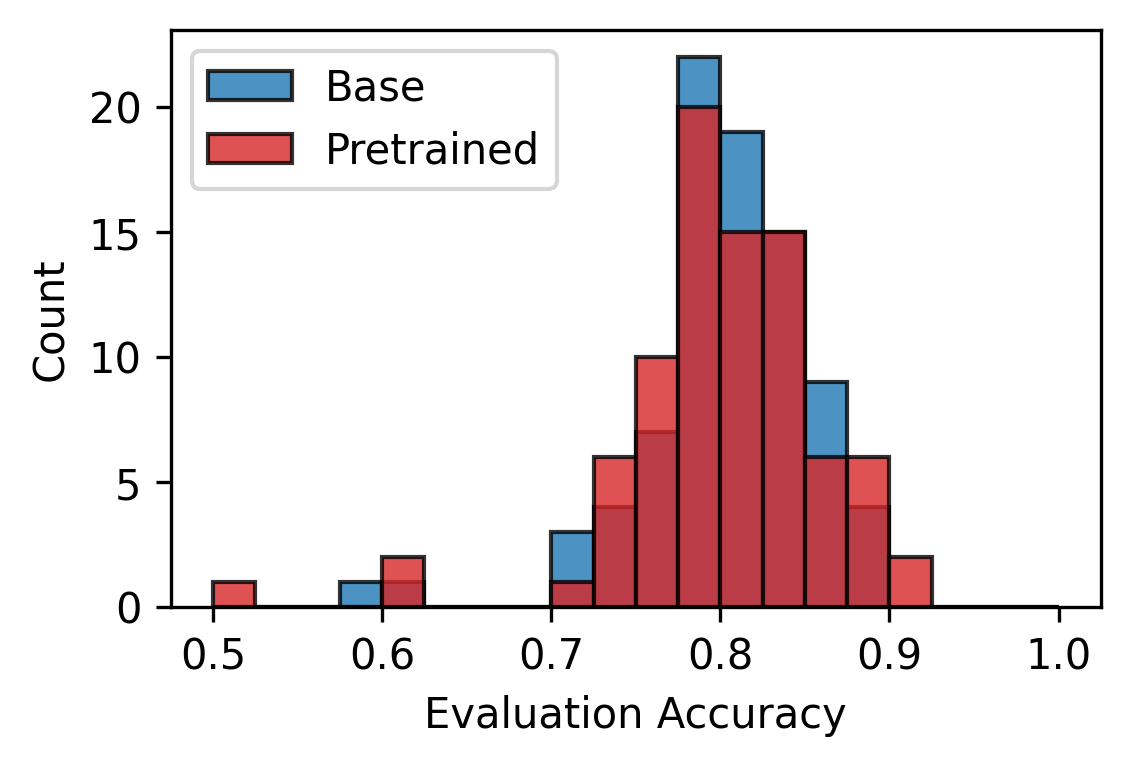

In [ ]:
bins = 20

fig, axs = plt.subplots(1, 1, dpi=300, figsize=(4, 2.5))

axs.hist(
    base["eval/accuracy"],
    label="Base",
    alpha=0.8,
    edgecolor="k",
    range=(0.5, 1),
    bins=bins,
    color="tab:blue",
)
axs.hist(
    pretrained["eval/accuracy"],
    label="Pretrained",
    alpha=0.8,
    edgecolor="k",
    range=(0.5, 1),
    bins=bins,
    color="tab:red",
)
axs.set_xlabel("Evaluation Accuracy")
axs.set_ylabel("Count")
plt.legend()

fig.show()

# Classification Metrics

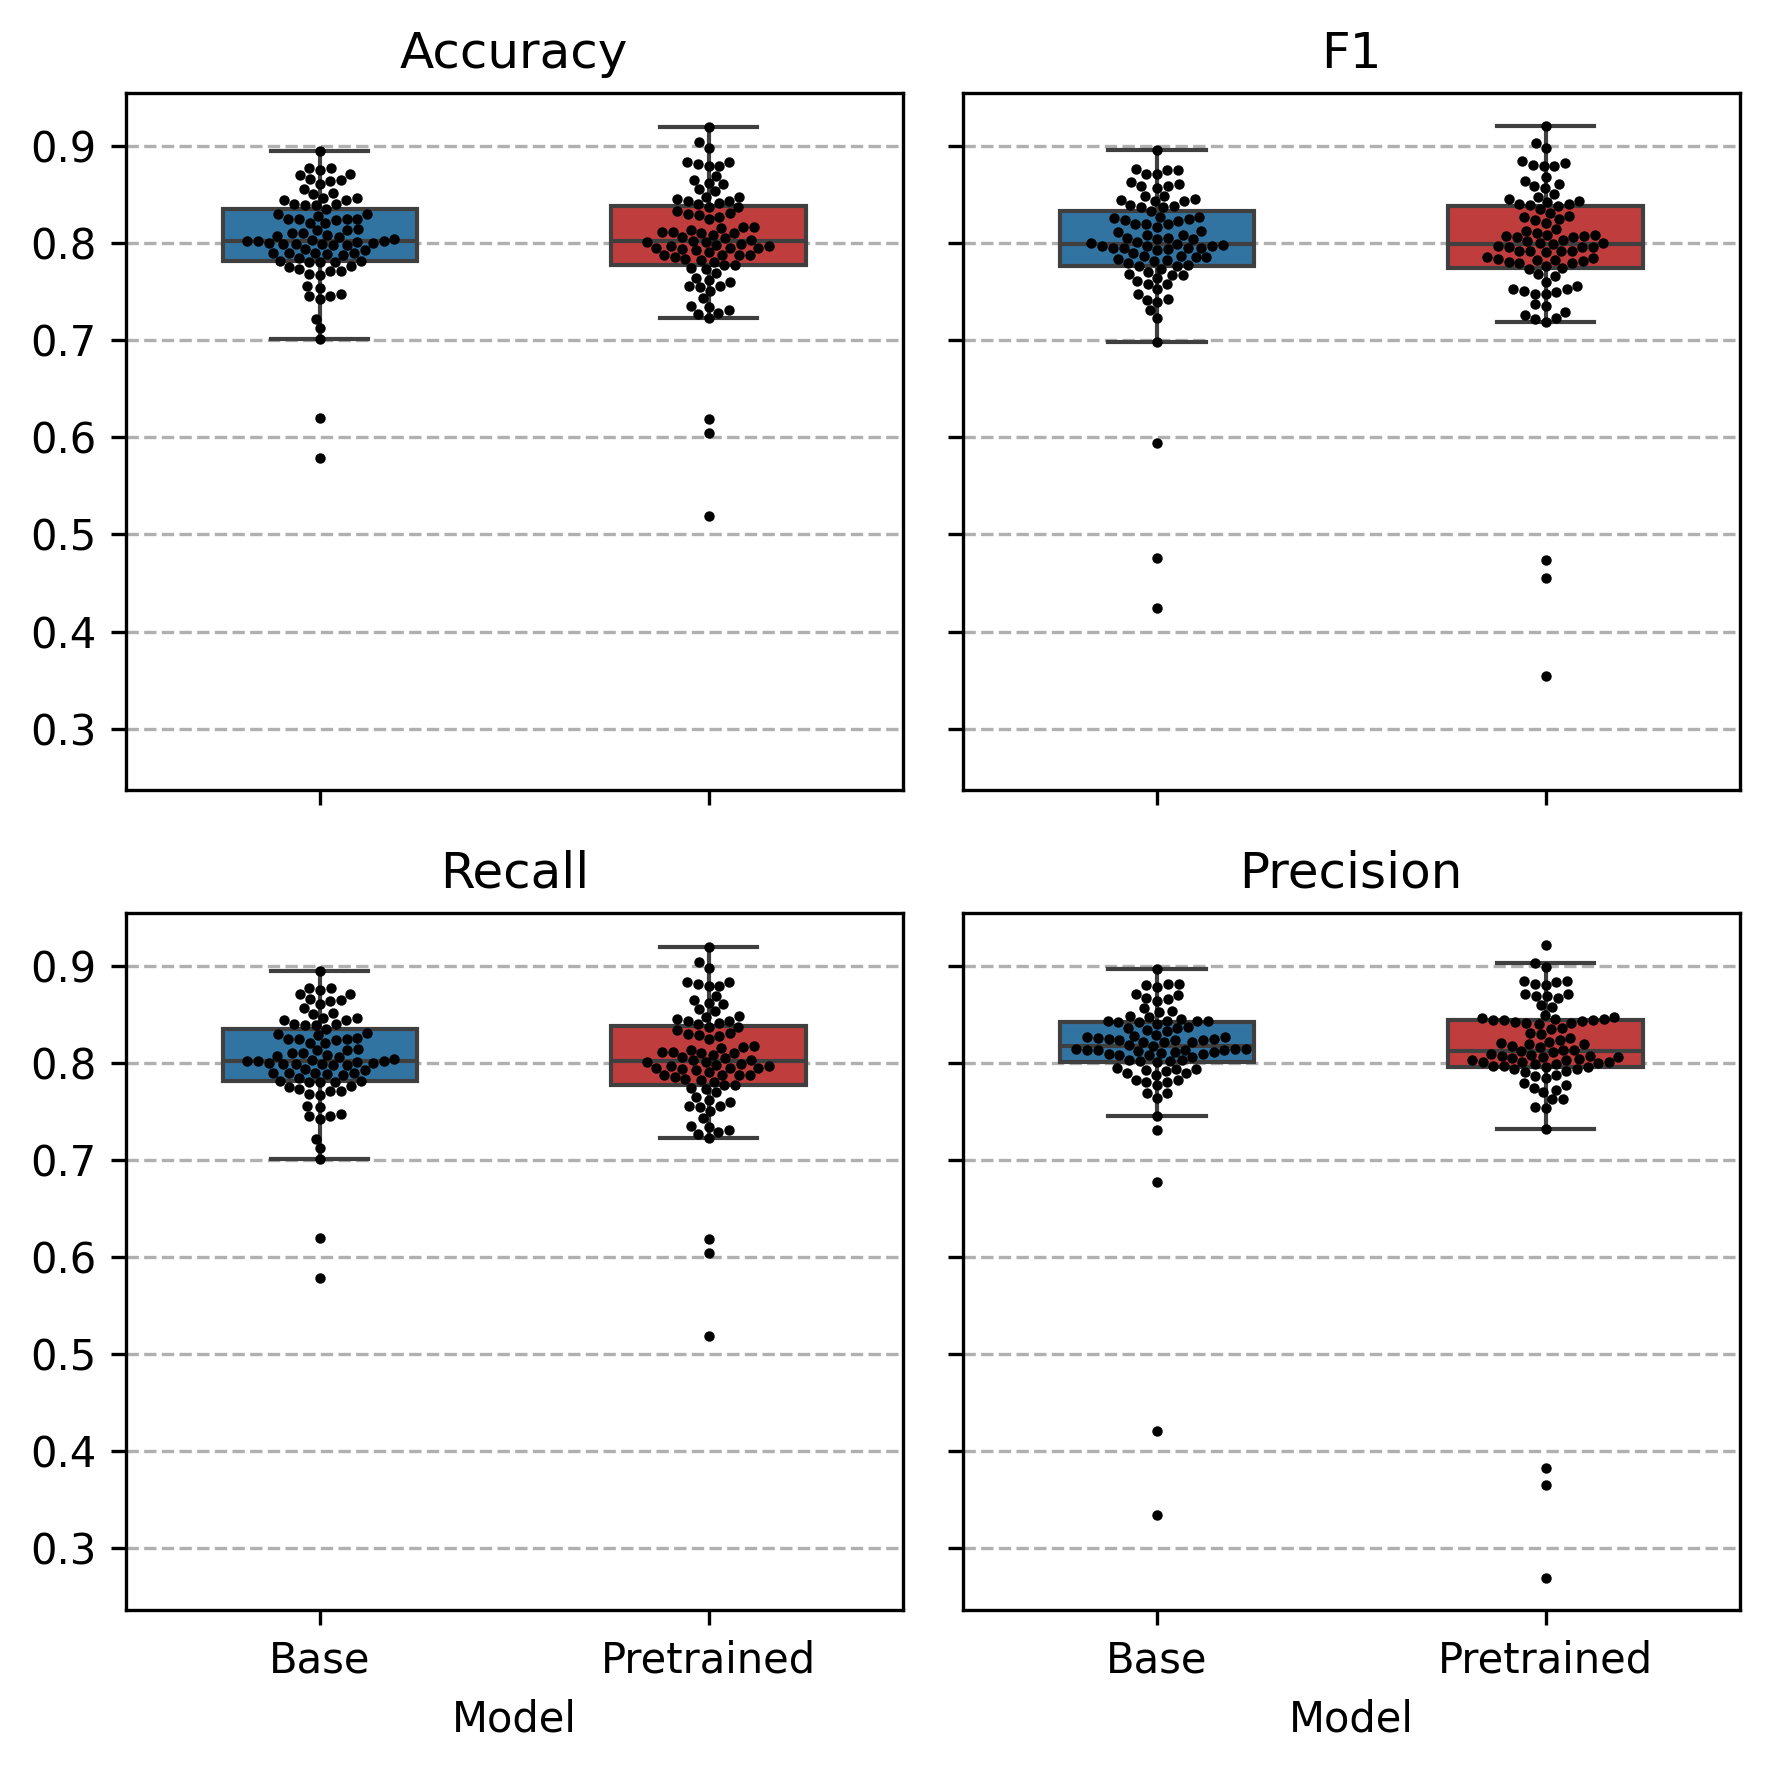

In [ ]:
tmp_df = pd.DataFrame(
    data={
        "Model": ["Base"] * len(base) + ["Pretrained"] * len(pretrained),
        "Accuracy": np.concat([base["eval/accuracy"], pretrained["eval/accuracy"]]),
        "F1": np.concat([base["eval/f1"], pretrained["eval/f1"]]),
        "Recall": np.concat([base["eval/recall"], pretrained["eval/recall"]]),
        "Precision": np.concat([base["eval/precision"], pretrained["eval/precision"]]),
    }
)

fig, axs = plt.subplots(2, 2, dpi=300, figsize=(6, 6), sharey=True, sharex=True)
fig.set_tight_layout(True)

for ax, metric in zip(axs.flatten(), ["Accuracy", "F1", "Recall", "Precision"]):
    ax.title.set_text(metric)
    sns.boxplot(
        tmp_df,
        x="Model",
        y=metric,
        palette=["tab:blue", "tab:red"],
        width=0.5,
        fliersize=0,
        ax=ax,
    ).set(ylabel=None)
    sns.swarmplot(
        tmp_df, x="Model", y=metric, c="k", size=2.5, ax=ax, rasterized=True
    ).set(ylabel=None)
    ax.grid(visible=True, axis="y", linestyle="--")
plt.show()

# Difference in Classification Accuracy Between Base and Pre-trained Models

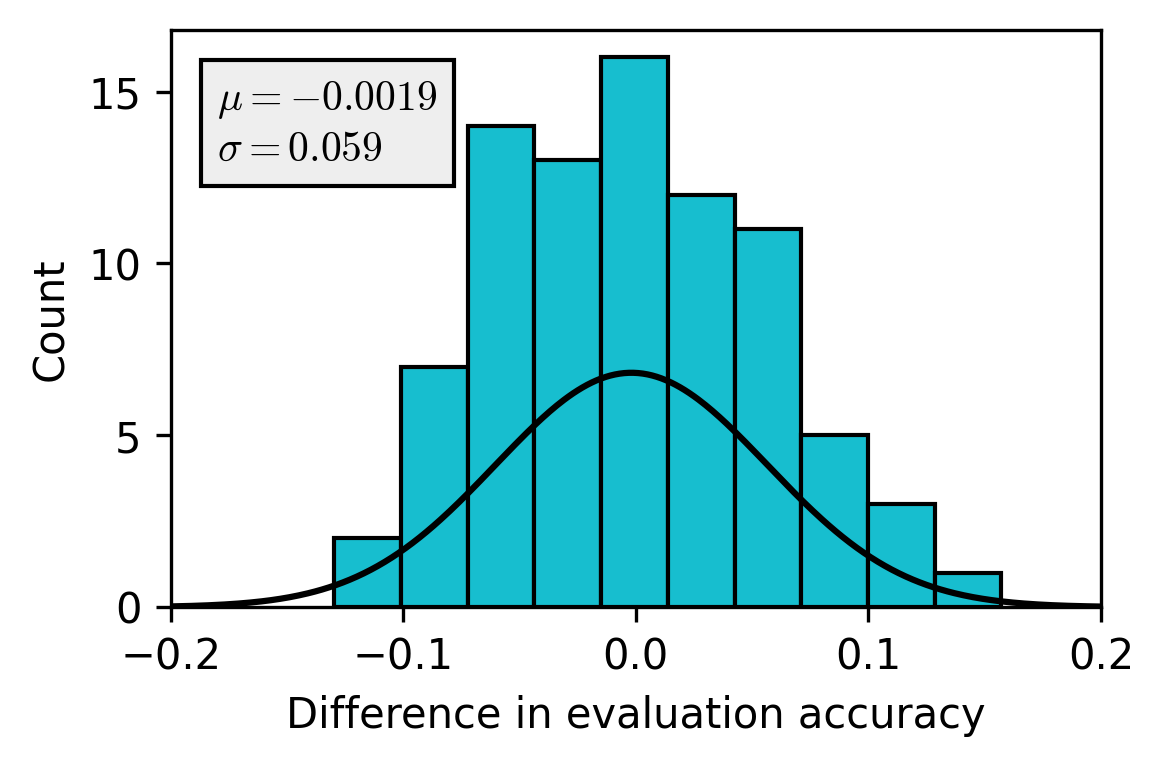

In [ ]:
deltas = []
for row in base.itertuples():
    pt = pretrained[pretrained["Notes"] == f'"Pretrained {row.ID}"']
    if pt.empty:
        continue

    dA = pt["eval/accuracy"] - row._8
    deltas.append(dA)

deltas = np.array(deltas)
mu_d = deltas.mean()
std_d = deltas.std()
x = np.arange(-0.2, 0.2, 0.001)
pdf = norm.pdf(x, mu_d, std_d)

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4, 2.5))
ax.set_xlim((-0.2, 0.2))
ax.plot(x, pdf, c="k")
ax.hist(deltas, edgecolor="k", density=False, bins=10, color="tab:cyan")
ax.text(
    -0.18,
    13,
    rf"$\mu = {mu_d:.2}$" "\n" rf"$\sigma = {std_d:.2}$",
    bbox={
        "facecolor": "#eee",
    },
)
ax.set_xlabel("Difference in evaluation accuracy")
ax.set_ylabel("Count")
ax.set_yticks([0, 5, 10, 15])
fig.show()

# T-Test 

In [ ]:
# Null hypothesis is that base models are equal or better than pretrained models
# Alternative hypothesis is that pretrained models are better than base models

base_eval = base["eval/accuracy"]
pretrained_eval = pretrained["eval/accuracy"]

t, p = ttest_ind(base_eval, pretrained_eval, alternative="less")

display(
    Latex(
        rf""" 
\begin{{align*}} 
&a_b \sim~ \mathcal{{N}}\left({np.mean(base_eval):.2};~{np.std(base_eval):.2}\right) \\ 
&a_p \sim~ \mathcal{{N}}\left({np.mean(pretrained_eval):.2};~{np.std(pretrained_eval):.2}\right) \\
&t = {t:.2f},~~p = {p:.2f}
\end{{align*}} 
    """
    )
)

<IPython.core.display.Latex object>

# Architecture 

In [ ]:
column_names = [
    "num_hidden_layers",
    "hidden_size",
    "hidden_act",
    "hidden_dropout_prob",
    "num_attention_heads",
    "attention_probs_dropout_prob",
    "intermediate_size",
    "layer_norm_eps",
    "max_position_embeddings",
    "per_device_train_batch_size",
]

v = df[column_names]

for i, a in enumerate(["silu", "relu", "gelu", "gelu_new"]):
    v.loc[v["hidden_act"] == a, "hidden_act"] = float(i)

v["max_position_embeddings"] -= 2

spec_matrix = np.array(v).T

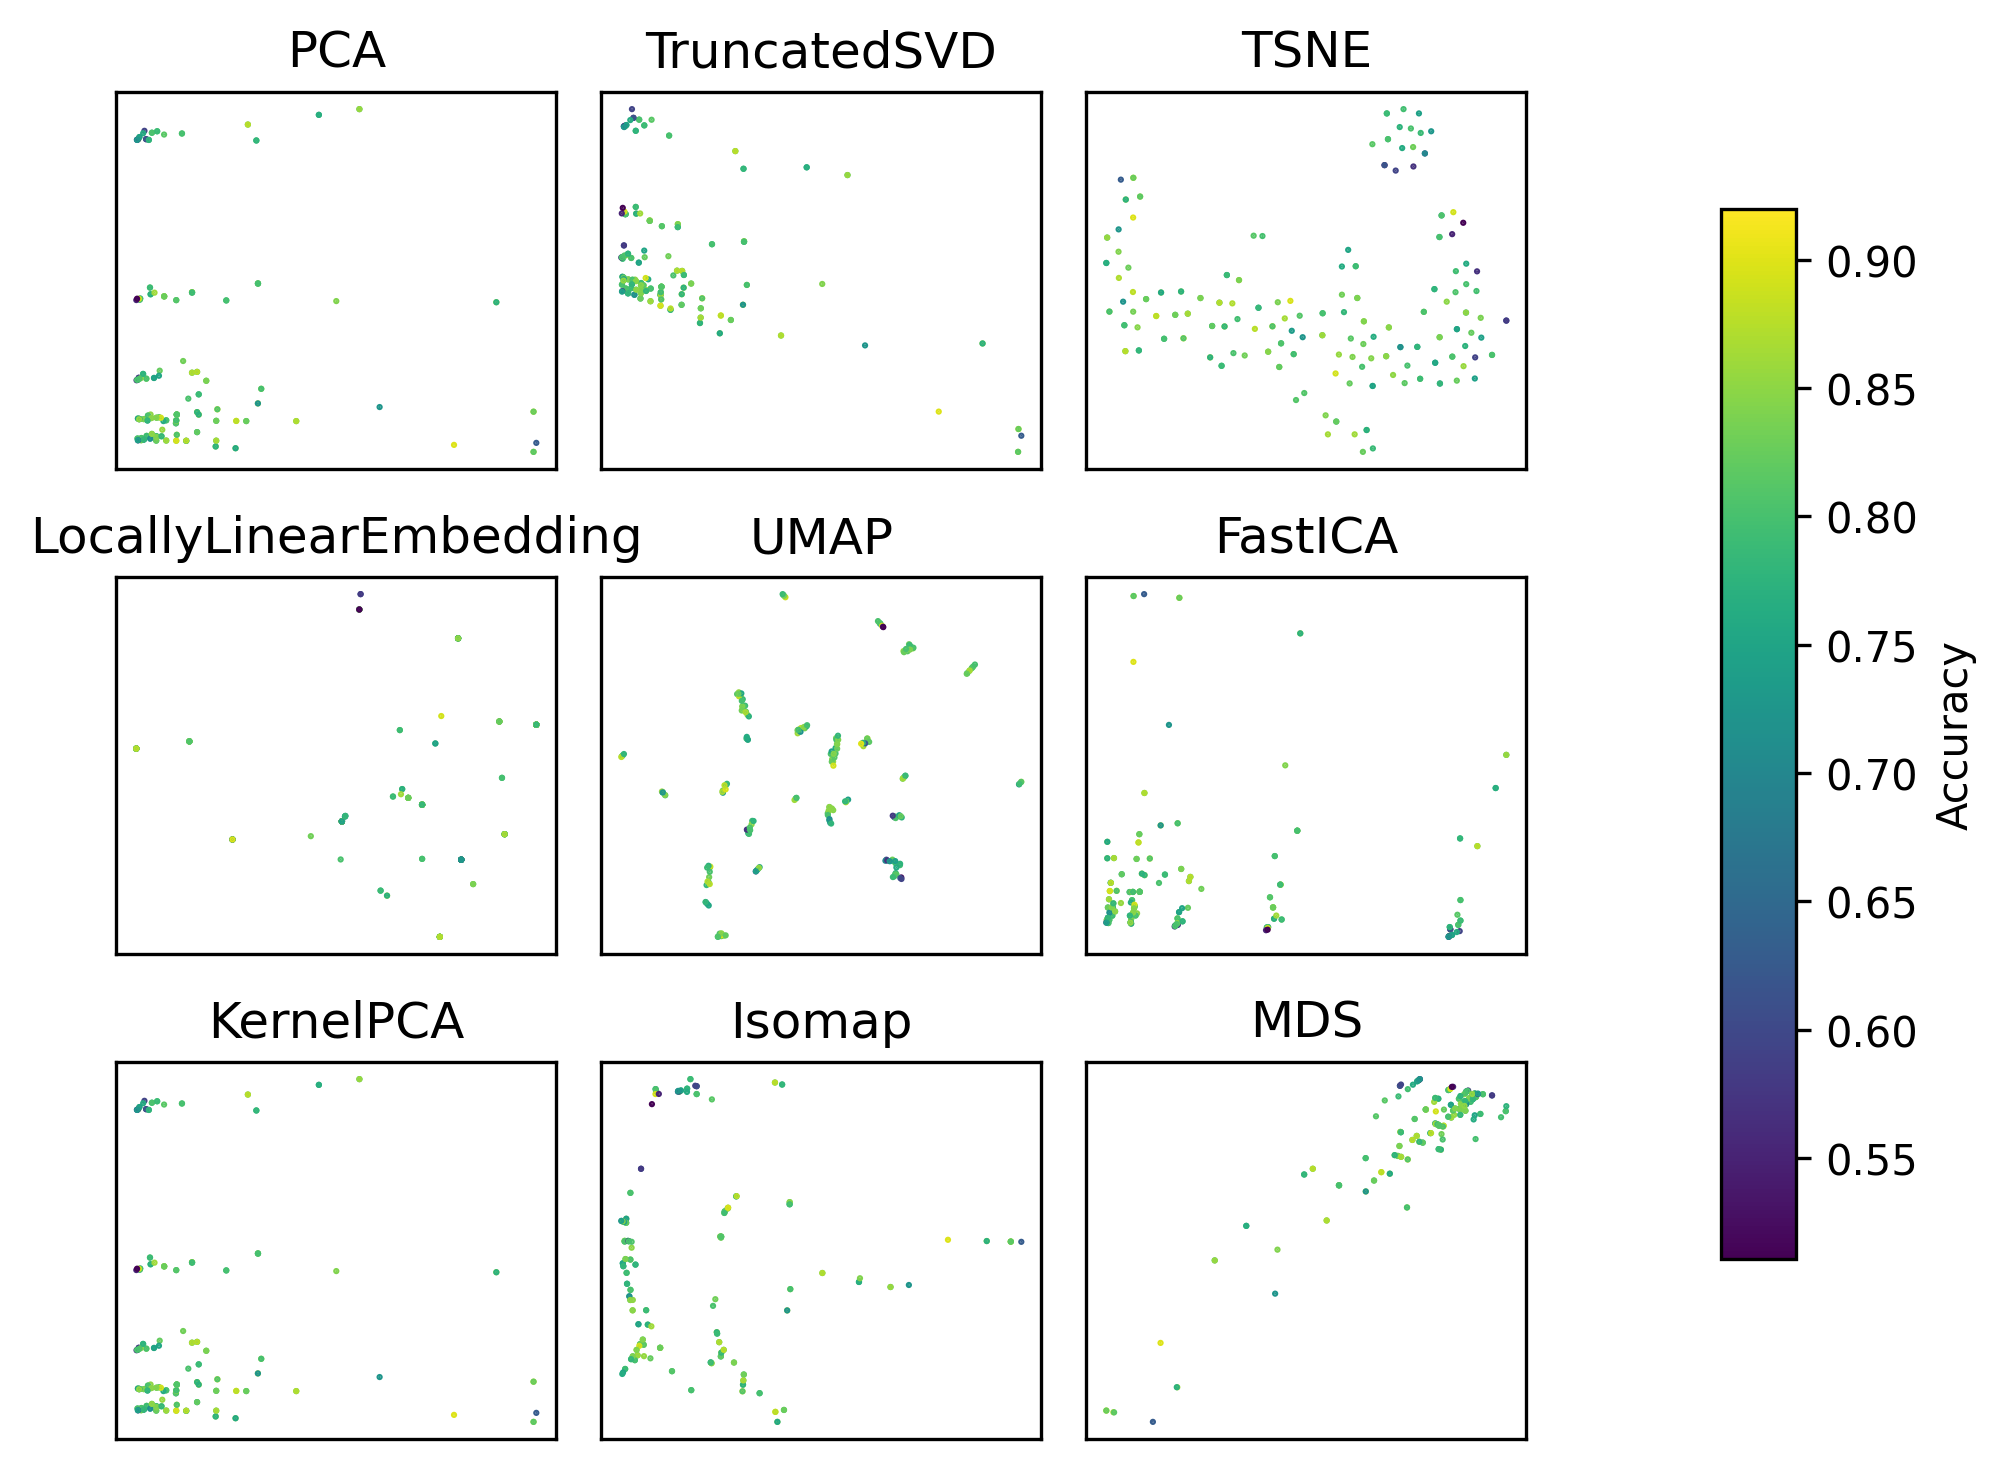

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, KernelPCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap, MDS


methods = [
    PCA(n_components=2, svd_solver="arpack"),
    TruncatedSVD(n_components=2),
    TSNE(n_components=2),
    LocallyLinearEmbedding(n_components=2),
    UMAP(n_components=2, n_neighbors=5, min_dist=0.5),
    FastICA(n_components=2),
    KernelPCA(n_components=2),
    Isomap(n_components=2),
    MDS(n_components=2),
]

fig, axs = plt.subplots(3, 3, dpi=300, figsize=(5, 5))
fig.set_tight_layout(True)
for reducer, axis in zip(methods, axs.flatten()):
    transformed = reducer.fit_transform(spec_matrix.T)

    ax = axis.scatter(
        transformed[:, 0], transformed[:, 1], c=df["eval/accuracy"], s=0.25
    )
    axis.set_xticks([])
    axis.set_yticks([])
    axis.title.set_text(reducer.__class__.__name__)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
fig.colorbar(ax, cax=cbar_ax, label="Accuracy")
# fig.colorbar(df['eval/accuracy'])